<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/book1/mlp/mlp_mnist_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLP on (Fashion) MNIST using TF 2.0

In [1]:

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. DNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

In [ ]:
# Standard Python libraries
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio
from IPython import display
import sklearn
from time import time

np.random.seed(0)

In [2]:
!git clone https://github.com/probml/pyprobml


Cloning into 'pyprobml'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 4299 (delta 1), reused 4 (delta 1), pack-reused 4291
Receiving objects: 100% (4299/4299), 166.78 MiB | 32.77 MiB/s, done.
Resolving deltas: 100% (2381/2381), done.


In [18]:
from pyprobml.scripts.mnist_helpers_tf import *

(60000, 28, 28)


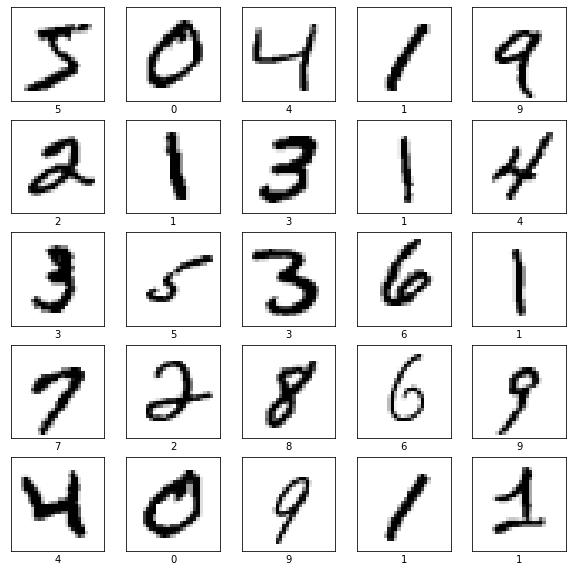

In [22]:
train_images, train_labels, test_images, test_labels, class_names=get_dataset(FASHION=False)
print(train_images.shape)
plot_dataset(train_images, train_labels, class_names)

In [23]:

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

model.summary()
    
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# We just train for 1 epochs because (1) it is faster, and
# (2) it produces more errors, which makes for a more interesting plot :)
time_start = time()
model.fit(train_images, train_labels, epochs=1)
print('time spent training {:0.3f}'.format(time() - time_start))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_________________________________________________________________
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2251 - accuracy: 0.9348
time spent training 5.591


In [24]:


# Overall accuracy
train_loss, train_acc = model.evaluate(train_images, train_labels)
print('Train accuracy:', train_acc)
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)

1875/1875 [==============================] - 3s 2ms/step - loss: 0.1158 - accuracy: 0.9630
Train accuracy: 0.9630333185195923
313/313 [==============================] - 1s 2ms/step - loss: 0.1279 - accuracy: 0.9597
Test accuracy: 0.9596999883651733


In [25]:
# To apply prediction to a single image, we need to reshape to an (N,D,D) tensor
# where N=1
img = test_images[0]
img = (np.expand_dims(img,0))
print(img.shape)
predictions_single = model.predict(img)
print(predictions_single.shape)

(1, 28, 28)
(1, 10)


(10000, 10)
(403,)


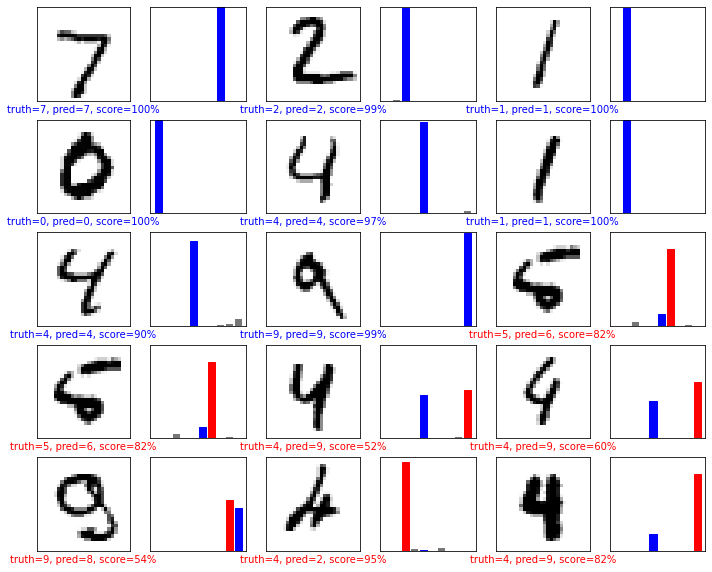

In [26]:
predictions = model.predict(test_images)
print(np.shape(predictions))
ndx = find_interesting_test_images(predictions, test_labels)
plot_interesting_test_results(test_images, test_labels, predictions, class_names, ndx)


In [27]:
model_epoch = model # save old model

# Train for 1 more epochs
time_start = time()
model.fit(train_images, train_labels, epochs=1)
print('time spent training {:0.3f}'.format(time() - time_start))

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0966 - accuracy: 0.9704
time spent training 3.488


In [ ]:

# Overall accuracy
train_loss, train_acc = model.evaluate(train_images, train_labels)
print('Train accuracy:', train_acc)
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0660 - accuracy: 0.9787
Train accuracy: 0.9787499904632568
313/313 [==============================] - 1s 2ms/step - loss: 0.0921 - accuracy: 0.9716
Test accuracy: 0.9715999960899353


(10000, 10)


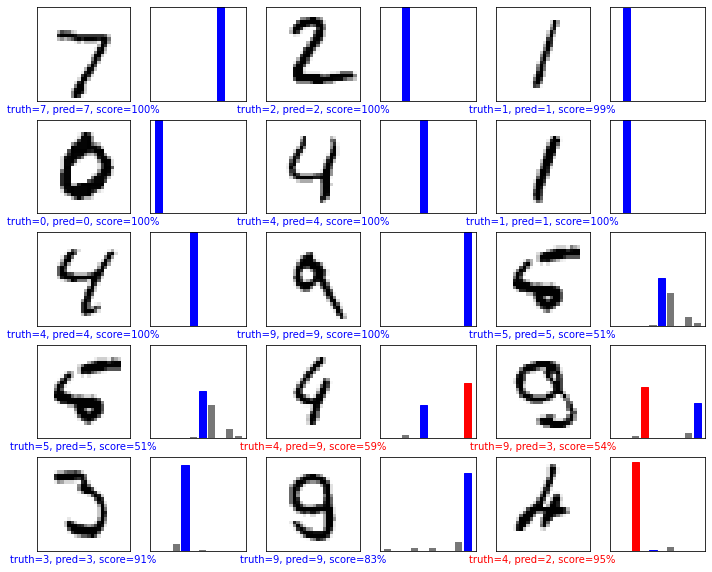

In [ ]:
predictions = model.predict(test_images)
print(np.shape(predictions))
#test_ndx = find_interesting_test_images(predictions) # re-use old inddices
plot_interesting_test_results(predictions, test_ndx)